In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import io
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.stats import t

UsageError: unrecognized arguments: 0


In [3]:
files = os.listdir("data")
dirs = [f for f in files if pathlib.Path("data", f).is_dir()]
dataframes = {
    d: {"files":{}} for d in dirs
}
for d in dirs:
    for f in os.listdir(os.path.join("data", d)):
        if f.endswith(".csv"):
            with open(os.path.join("data", d,f), "r") as file:
                filedata = file.read()
                lines = filedata.split("\n")

                names = lines[0].strip().split(",")[::2]

                timestamps = lines[1].strip().split(",")[1::2] # 2025-07-01 15:58:16
                timestamps = [t.split(" ")[1] for t in timestamps] # 15:58:16
                timestamps = np.array(list(pd.to_datetime(t, format="%H:%M:%S") for t in timestamps))
                

                order = np.argsort(timestamps)

                timestamps = timestamps[order]
                timestamps_unique = timestamps[::4]
                basetime = timestamps_unique[0]
                timestamps_unique = [(t - basetime) for t in timestamps_unique]
                names = np.array(names)[order]
                names_unique = np.array(list(n.split(":")[0] for n in names[::4]))

                order_cols = np.zeros(len(timestamps)*2, dtype=np.int32) #every timestamp has two columns, one for the potential and one for the current
                order_pot = order*2
                order_curr = order*2 + 1

                csv_str = "\n".join(filedata.split("\n")[3:])
                csv_data = pd.read_csv(io.StringIO(csv_str),header=None,dtype=np.float32)
                pot_df = csv_data.iloc[:, order_pot]
                curr_df = csv_data.iloc[:, order_curr]
                
                curr_df_mean = pd.DataFrame()
                pot_df_mean = pd.DataFrame()
                #every column of pot_df_mean and curr_df_mean is the mean of 4 columns of pot_df and curr_df (assume that every cyclic voltammogram has 4 cycles)
                for i in range(0, len(pot_df.columns), 4):
                    pot_mean = pot_df.iloc[:, i:i+4].mean(axis=1)
                    curr_mean = curr_df.iloc[:, i:i+4].mean(axis=1)
                    pot_df_mean[f"{timestamps_unique[i//4]}"] = pot_mean
                    curr_df_mean[f"{timestamps_unique[i//4]}"] = curr_mean
                curr_df_top = curr_df_mean.iloc[0:41,:]
                curr_df_bottom = pd.concat([curr_df_mean.iloc[0:1,:],curr_df_mean.iloc[40:,:][::-1]]) #copy the first row and append the last 40 rows inverted
                pot_df_top = pot_df_mean.iloc[0:41,:]
                pot_df_bottom = pd.concat([pot_df_mean.iloc[0:1,:],pot_df_mean.iloc[40:,:][::-1]]) #copy the first row and append the last 40 rows inverted
                
                dataframes[d]["files"][f] = {
                    "timestamps": timestamps_unique,
                    "names": names_unique,
                    "pot_df_top": pot_df_top,
                    "pot_df_bottom": pot_df_bottom, 
                    "curr_df_top": curr_df_top,
                    "curr_df_bottom": curr_df_bottom,
                }








In [4]:
# in the dictionary we have x values (potentials) and y values (currents) for each timestamp
# first, combine the x values into a single array
for dir in dataframes:
    max_x = max([ts[-1].total_seconds() for ts in [dataframes[dir]["files"][x]["timestamps"] for x in dataframes[dir]["files"]]])
    x_interp = np.linspace(0, max_x, 1000)  # Create a common x-axis for interpolation
    
    interpfun = []
    for file in dataframes[dir]["files"]:
        names = dataframes[dir]["files"][file]["names"]
        timestamps = dataframes[dir]["files"][file]["timestamps"]
        pot_df_top = dataframes[dir]["files"][file]["pot_df_top"]
        pot_df_bottom = dataframes[dir]["files"][file]["pot_df_bottom"]
        curr_df_top = dataframes[dir]["files"][file]["curr_df_top"]
        curr_df_bottom = dataframes[dir]["files"][file]["curr_df_bottom"]
        # combine the x values
        time_area = []
        for i,ts in enumerate(timestamps):
            x_values = np.union1d(pot_df_top.iloc[:,i], pot_df_bottom.iloc[:,i])
            f_top = interp1d(pot_df_top.iloc[:,i], curr_df_top.iloc[:,i], fill_value="extrapolate")
            f_bottom = interp1d(pot_df_bottom.iloc[:,i], curr_df_bottom.iloc[:,i], fill_value="extrapolate")
            y_top_common = f_top(x_values)
            y_bottom_common = f_bottom(x_values)
            diff = np.abs(y_top_common - y_bottom_common)
            area = np.trapezoid(diff, x_values)
            time_area.append([ts.total_seconds(), area])
        areas_df = pd.DataFrame(time_area, columns=["time", "area"])
        areas_df["areanorm"] = areas_df["area"]/areas_df["area"].iloc[0]  # Normalize
        dataframes[dir]["files"][file]["areas"] = areas_df
        f_interp = interp1d(areas_df["time"], areas_df["areanorm"], fill_value="extrapolate",kind = "linear")
        interpfun.append(f_interp)

    y_avg = np.mean([f(x_interp) for f in interpfun], axis=0)
    y_avg /= y_avg[0]  # Normalize the average function by the first value
    y_std = np.std([f(x_interp) for f in interpfun], axis=0)
    dataframes[dir]["f_avg"] = (x_interp, y_avg, y_std)


t-score for 0.1mA with 2 degrees of freedom: 1.39
t-score for 0.2mA with 1 degrees of freedom: 1.96
t-score for 0.3mA with 1 degrees of freedom: 1.96


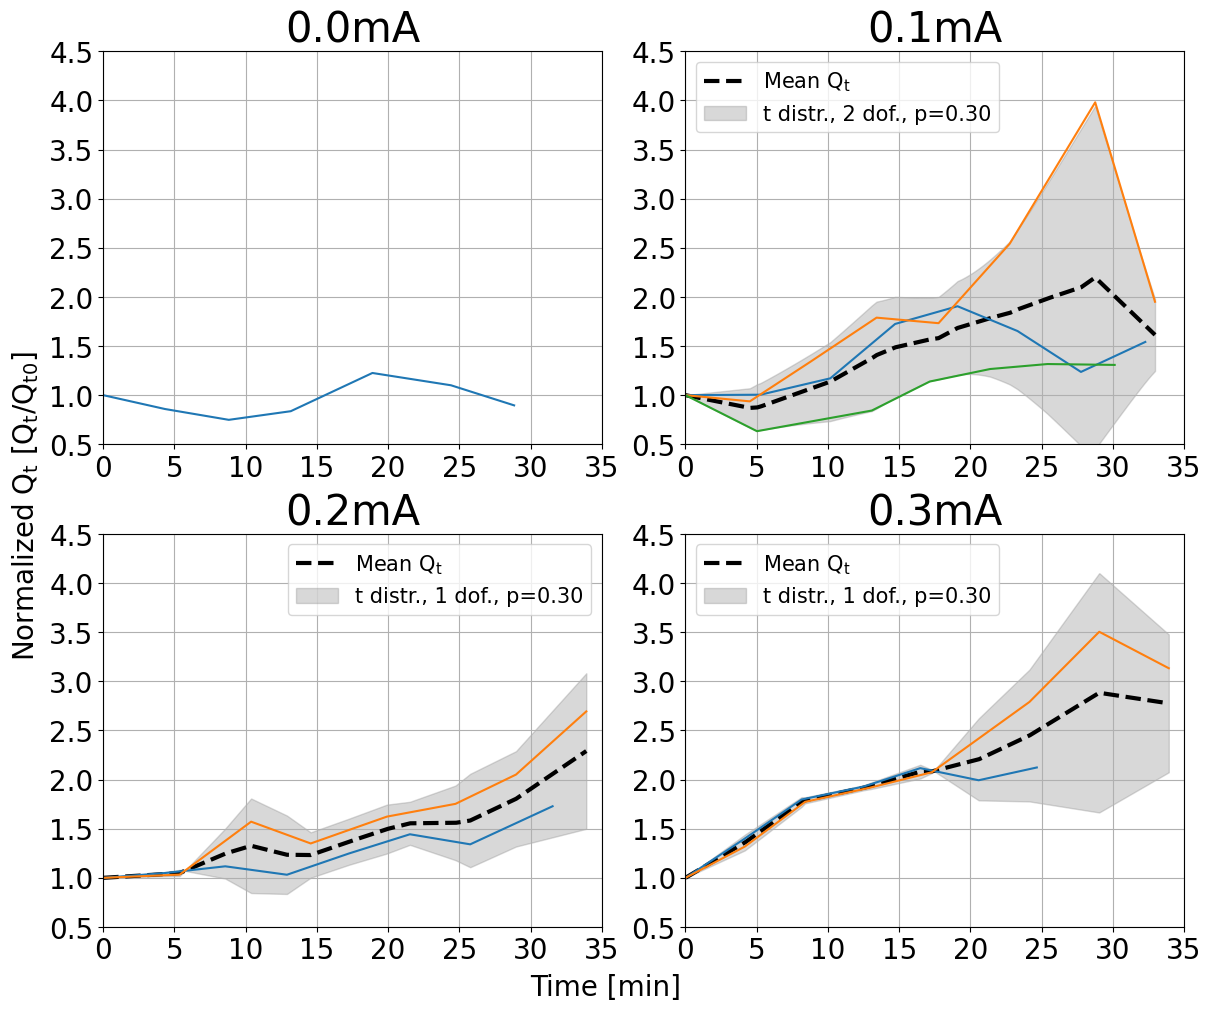

In [11]:
fig,ax = plt.subplots(2,2,figsize=(12, 10),constrained_layout=True)
ax = ax.flatten()
xticks = np.arange(0, 2400, 300)
xlabels = [f"{i//60}" for i in xticks]
fig.supxlabel("Time [min]", fontsize=20)
fig.supylabel("Normalized $\mathregular{Q_{t}}$ [$\mathregular{Q_{t}}$/$\mathregular{Q_{t0}}$]", fontsize=20)
for axidx,dir in enumerate(dataframes):
    curr_ax = ax[axidx]
    curr_ax.set_title(f"{dir}",fontsize=30)
    curr_ax.set_ylim((0.5, 4.5))
    curr_ax.set_xlim((0, 2100))
    curr_ax.set_xticks(xticks,xlabels, fontsize=20)
    curr_ax.set_yticks(np.linspace(0.5,4.5,9),np.linspace(0.5,4.5,9),fontsize=20)
    curr_ax.grid()
    if(len(dataframes[dir]["files"]) > 1):
        deg_freedom = len(dataframes[dir]["files"]) - 1
        alpha = 0.3
        t_score = t.ppf(1 - alpha/2, deg_freedom)  # two-tailed t-test
        print(f"t-score for {dir} with {deg_freedom} degrees of freedom: {t_score:.2f}")
        x_avg, y_avg, y_std = dataframes[dir]["f_avg"]
        curr_ax.plot(x_avg,y_avg, label="Mean $\mathregular{Q_{t}}$", color="black", linestyle="--",linewidth=3)
        curr_ax.fill_between(x_avg, 
                             y_avg - y_std*t_score, 
                             y_avg + y_std*t_score, 
                             color="gray", alpha=0.3, label=f"t distr., {deg_freedom} dof., p={alpha:.2f}")
        
        curr_ax.legend(fontsize=15)
    for file in dataframes[dir]["files"]:
        areas_df = dataframes[dir]["files"][file]["areas"]
        curr_ax.plot(areas_df["time"], areas_df["areanorm"], label=None)
plt.show()

t-score for 0.0mA with 0 degrees of freedom: nan
t-score for 0.1mA with 2 degrees of freedom: 1.39
t-score for 0.2mA with 1 degrees of freedom: 1.96
t-score for 0.3mA with 1 degrees of freedom: 1.96


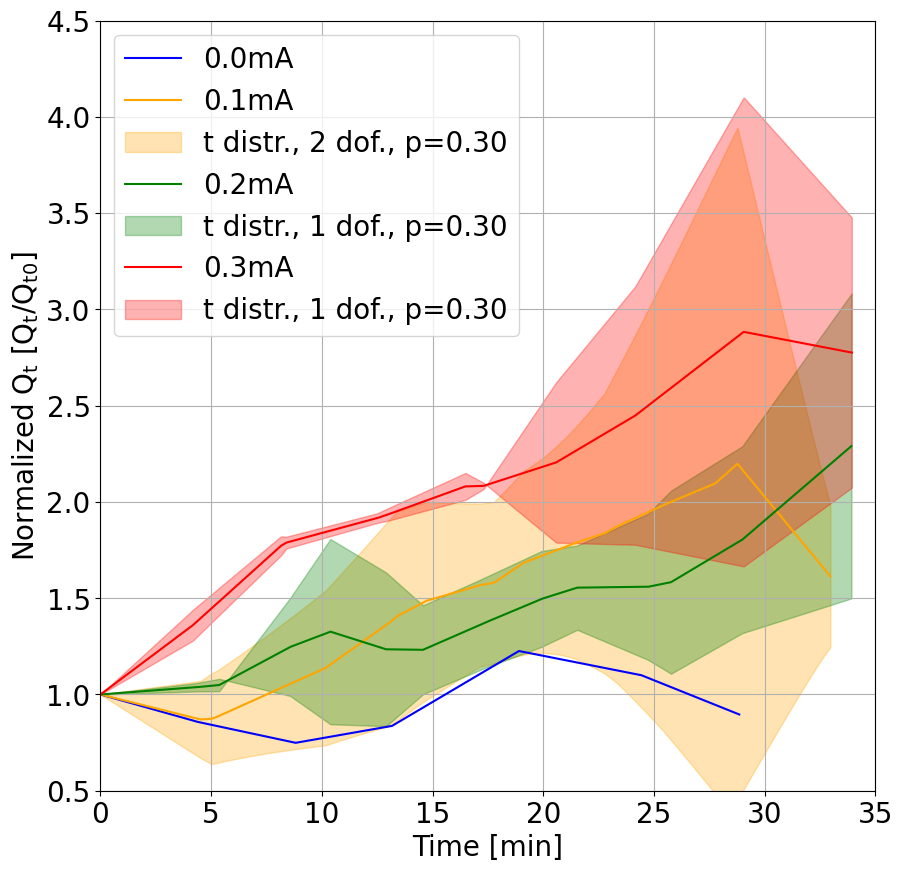

In [9]:
# plot only averages in the same figure
colors = ["blue", "orange", "green", "red"]
fig = plt.figure(figsize=(10, 10))
xticks = np.arange(0, 2400, 300)
xlabels = [f"{i//60}" for i in xticks]
for i,dir in enumerate(dataframes):
    x_avg, y_avg,y_dev = dataframes[dir]["f_avg"]
    plt.plot(x_avg, y_avg, label=dir,color = colors[i])
    deg_freedom = len(dataframes[dir]["files"]) - 1
    alpha = 0.3
    t_score = t.ppf(1 - alpha/2, deg_freedom)  # two-tailed t-test
    print(f"t-score for {dir} with {deg_freedom} degrees of freedom: {t_score:.2f}")
    if(len(dataframes[dir]["files"]) > 1):
        plt.fill_between(x_avg, 
                        y_avg - y_dev*t_score, 
                        y_avg + y_dev*t_score, 
                        alpha=0.3,color = colors[i], label=f"t distr., {deg_freedom} dof., p={alpha:.2f}")
plt.xticks(xticks, xlabels,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Normalized $\mathregular{Q_{t}}$ [$\mathregular{Q_{t}}$/$\mathregular{Q_{t0}}$]",fontsize=20)
plt.xlabel("Time [min]",fontsize=20)
plt.ylim((0.5, 4.5))
plt.xlim((0, 2100))
plt.grid()
plt.legend(fontsize=20)

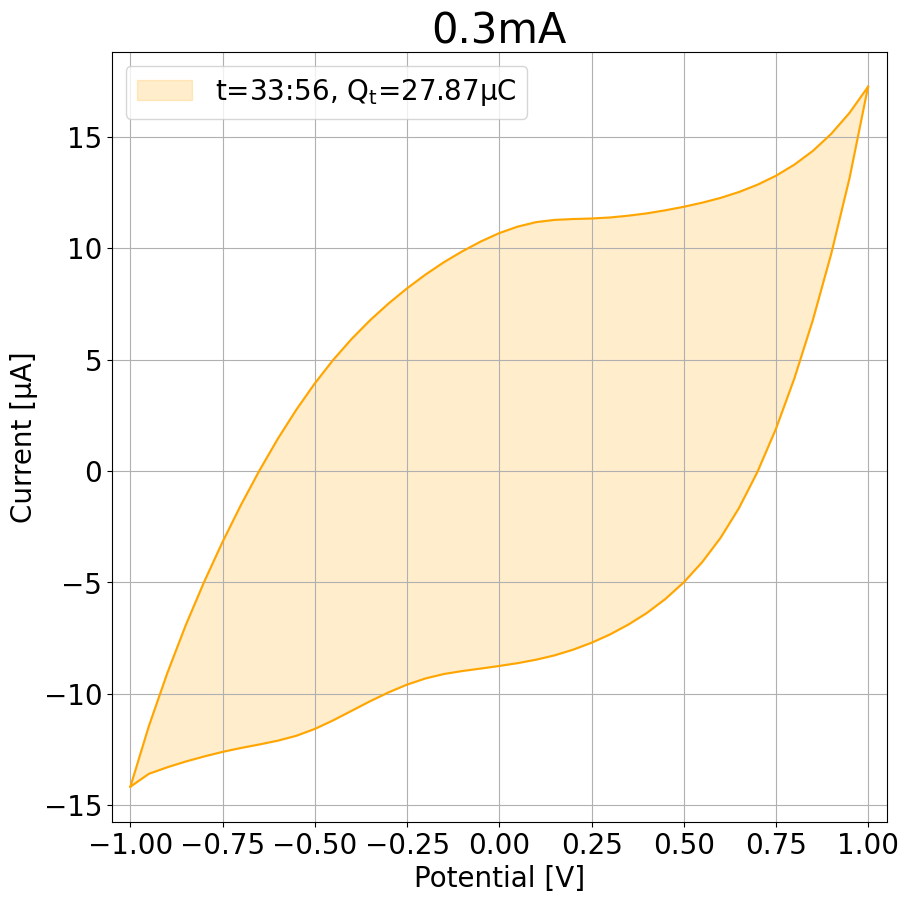

In [12]:
plt.figure(figsize=(10, 10))
colors = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray"]
curr = "0.3mA"
file = "2.csv"
for i in range(len(dataframes[curr]["files"][file]["timestamps"])-1,len(dataframes[curr]["files"][file]["timestamps"]),2):
    pot_top = dataframes[curr]["files"][file]["pot_df_top"].iloc[:,i]
    pot_bottom = dataframes[curr]["files"][file]["pot_df_bottom"].iloc[:,i]    
    curr_top = dataframes[curr]["files"][file]["curr_df_top"].iloc[:,i]
    curr_bottom = dataframes[curr]["files"][file]["curr_df_bottom"].iloc[:,i]
    timestamp = dataframes[curr]["files"][file]["timestamps"][i]
    tf_mins = int(timestamp.total_seconds()//60)
    tf_secs = timestamp.total_seconds()%60
    plt.plot(pot_top, curr_top, color=colors[i//2])
    plt.plot(pot_bottom, curr_bottom, color=colors[i//2])
    plt.fill_between(pot_top, curr_bottom, curr_top, color=colors[i//2], alpha=0.2,label="t={:02}:{:02}, $\mathregular{{Q_{{t}}}}$={:.4}μC".format(tf_mins, int(tf_secs),dataframes[curr]["files"][file]["areas"].iloc[i,1]))
    plt.xlabel("Potential [V]", fontsize=20)
    plt.ylabel("Current [μA]", fontsize=20)
    plt.xlim((-1.05, 1.05))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.title(f"{curr}",fontsize=30)


In [ ]:
for dir in dataframes:
    #print last 
    print(f"{dir} : ")